Disclaimer: Keep in mid that a jupyter notebook is a finished job, 
the thinking and needed adaptions were removed as the projects grows

In [29]:
# Imports 
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import os
import datetime as dt
plt.rcParams['figure.dpi'] = 140
%matplotlib inline

In [37]:
df = pd.read_csv('netflix_titles.csv') #Netflix Dataset
df.head() # Shows 5 first rows on the dataframe

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,520476.0,"AT, CH, DE"
1,Kill Bill: Vol. 1,movie,"Action, Crime, Thriller",2003.0,tt0266697,8.2,1232113.0,"AE, AL, AO, AT, AU, AZ, BG, BH, BY, CI, CM, CZ..."
2,Jarhead,movie,"Biography, Drama, War",2005.0,tt0418763,7.0,213209.0,"AD, AE, AG, AO, BH, BM, BS, BZ, CI, CM, CO, CR..."
3,Unforgiven,movie,"Drama, Western",1992.0,tt0105695,8.2,447667.0,"AU, BA, BG, CZ, HR, HU, MD, ME, MK, NZ, PL, RO..."
4,Eternal Sunshine of the Spotless Mind,movie,"Drama, Romance, Sci-Fi",2004.0,tt0338013,8.3,1117918.0,"AD, AE, AG, AL, AO, AR, AU, AZ, BA, BB, BE, BG..."


The dataset is pretty much the content you can see on the default page in netflix, let's see what the informations show to us.

In [38]:
# Analysis 
for col in df.columns:
    null_rate = 100*df[col].isna().sum() / df.shape[0]
    if null_rate > 0 :
        print("{} null rate: {}%".format(col,round(null_rate,2)))

title null rate: 2.97%
genres null rate: 1.6%
releaseYear null rate: 0.16%
imdbId null rate: 7.18%
imdbAverageRating null rate: 8.07%
imdbNumVotes null rate: 8.07%


# Netflix pallete 
Consistency in color scheme across all visual materials helps reinforce brand identity. When your audience sees familiar colors, they immediately associate the visuals with your brand, creating a sense of trust and recognition.

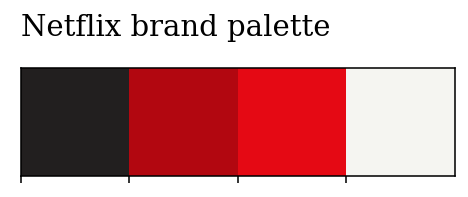

In [39]:
sns.palplot(['#221f1f', '#b20710', '#e50914','#f5f5f1'])
plt.title("Netflix brand palette ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

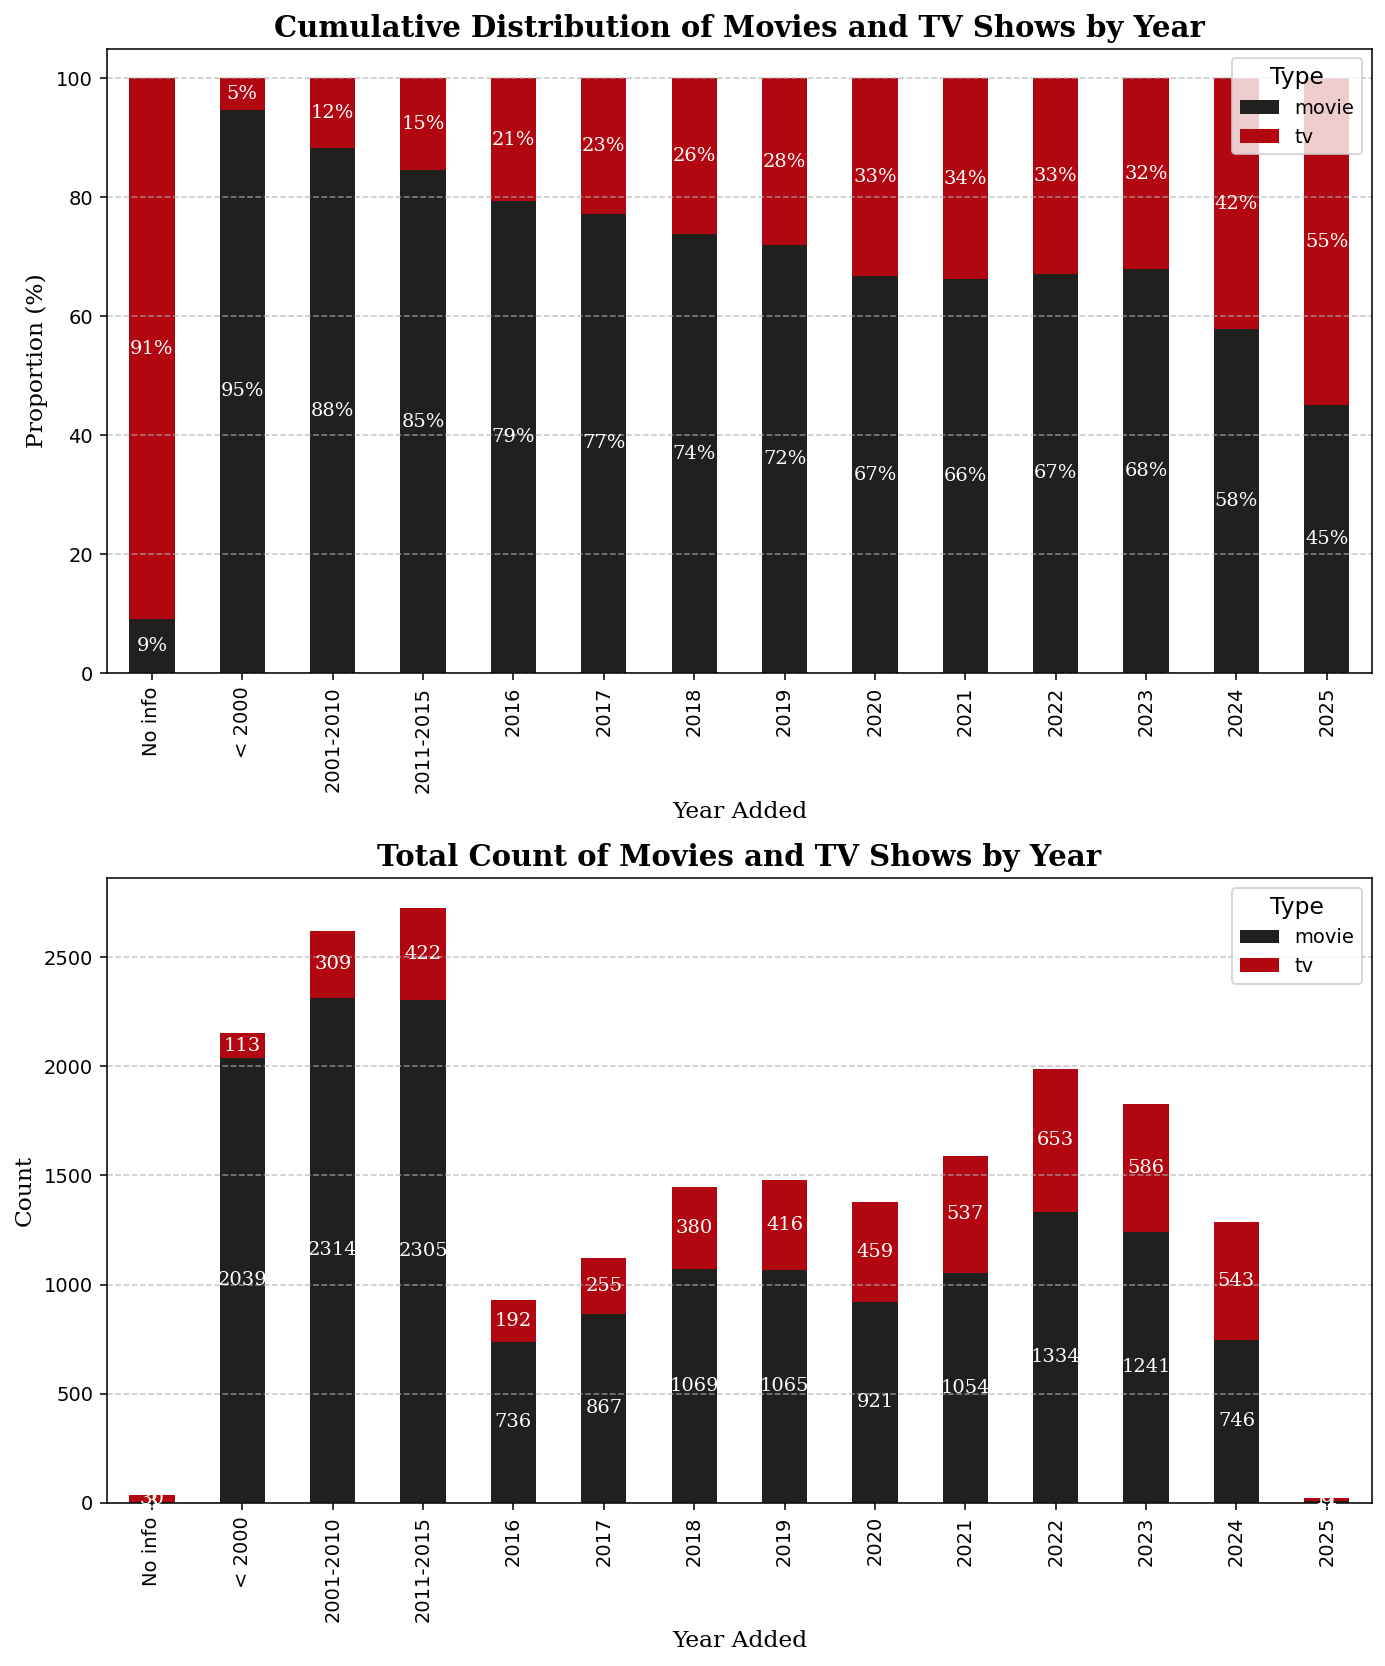

In [45]:
# Define custom function to group years
def group_years(year):
    if pd.isna(year):
        return 'No info'
    if year < 2000:
        return '< 2000'
    elif 2000 <= year <= 2010:
        return '2001-2010'
    elif 2011 <= year <= 2015:
        return '2011-2015'
    else:
        return str(int(year))
    
df['releaseYearGroup'] = df['releaseYear'].apply(group_years)


# Define the desired order for the x-axis
year_order = ['No info','< 2000', '2001-2010', '2011-2015'] + \
sorted(df[df['releaseYear'] >= 2016]['releaseYear'].astype(int).astype(str).unique().tolist())


from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=year_order, ordered=True) 
df['releaseYearGroup'] = df['releaseYearGroup'].astype(cat_type)


counts = df.groupby(['releaseYearGroup', 'type']).size().unstack().fillna(0)

# Calculate the percentage of each type per year
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Create subplots for vertical comparison
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot the stacked bar chart for percentages
colors = ['#221f1f', '#b20710']
percentages.plot(kind='bar', stacked=True, color=colors, ax=axes[0])

# Add percentages on the bars
for i in axes[0].containers:
    axes[0].bar_label(i, label_type='center', fmt='%.0f%%', fontsize=10, fontweight='light', fontfamily='serif', color='white')

# Set title and labels for the percentage chart
axes[0].set_title('Cumulative Distribution of Movies and TV Shows by Year', fontsize=15, fontweight='bold', fontfamily='serif')
axes[0].set_xlabel('Year Added', fontsize=12, fontfamily='serif')
axes[0].set_ylabel('Proportion (%)', fontsize=12, fontfamily='serif')
axes[0].legend(title='Type', fontsize=10, title_fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot the stacked bar chart for absolute counts
counts.plot(kind='bar', stacked=True, color=colors, ax=axes[1])

# Add counts on the bars
for i in axes[1].containers:
    axes[1].bar_label(i, label_type='center', fmt='%d', fontsize=10, fontweight='light', fontfamily='serif', color='white')

# Set title and labels for the count chart
axes[1].set_title('Total Count of Movies and TV Shows by Year', fontsize=15, fontweight='bold', fontfamily='serif')
axes[1].set_xlabel('Year Added', fontsize=12, fontfamily='serif')
axes[1].set_ylabel('Count', fontsize=12, fontfamily='serif')
axes[1].legend(title='Type', fontsize=10, title_fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Gathered infos

- The  of TV Shows relative to Movies has increased significantly over the years, growing from about 5.3% before 2000 to 55.0% in 2025.
- There was a steady growth in the percentage of TV Shows from 2017 to 2021, reaching approximately 33.8% in 2021.
- The highest combined production of Movies and TV Shows was in 2019.
- There was a noticeable jump in the proportion of TV Shows in 2024, reaching 42.1%.

## Genres
Evaluating genres is a approach that not only enhances content creation and marketing strategies but also plays a vital role in many aspects of netflix business.

In [49]:
df['genres'].value_counts().head(5)
#The first thing we see is that we have multiple combinations of genres in the same title.

genres
Comedy            1739
Drama             1695
Documentary        983
Comedy, Drama      789
Drama, Romance     655
Name: count, dtype: int64

# Few approachs

- Comparing IMDb Performance of Single vs. Multiple Genres:

This analysis will compare the average IMDb ratings of titles with single genres against those with multiple genres. The goal is to determine if having multiple genres influences the rating positively or negatively.

- Summing Titles Across Multiple Genres:

This approach will count each title in all its genres. For example, if a title belongs to both "Action" and "Comedy," it will be counted in both categories. This will help identify which genres are most prevalent.

- Primary Genre Analysis:

By considering the first genre listed as the primary genre, this analysis will investigate whether the primary genre has any significant impact on the IMDb ratings compared to secondary genres.

- Changes Over the Years:

This analysis will examine how the distribution and performance of genres have changed over different release year groups. It will help identify trends and shifts in genre popularity and performance.

- Comparison Between Movies and TV Shows:

This analysis will compare the performance and distribution of genres between movies and TV shows. The aim is to see if certain genres perform better in movies compared to TV shows and vice versa.



#### 1. Comparing IMDb Performance of Single vs. Multiple Genres

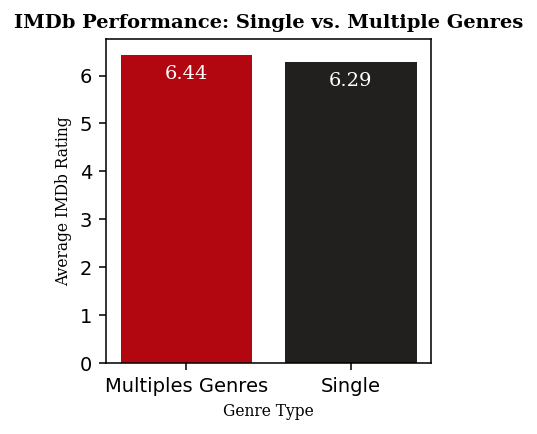

In [68]:
df['genre_count'] = df['genres'].fillna('No info').str.split(',').apply(len)

df['single_or_multiple'] = df['genre_count'].apply(lambda x: 'Single' if x == 1 else 'Multiples Genres')

imdb_performance = df.groupby('single_or_multiple')['imdbAverageRating'].mean().reset_index()

fig, ax = plt.subplots(figsize=(3,3))
ax.bar(imdb_performance['single_or_multiple'], imdb_performance['imdbAverageRating'], color=['#b20710', '#221f1f'])

ax.set_title('IMDb Performance: Single vs. Multiple Genres', fontsize=10, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Genre Type', fontsize=8, fontfamily='serif')
ax.set_ylabel('Average IMDb Rating', fontsize=8, fontfamily='serif')

for i in range(len(imdb_performance)):
    ax.text(i, imdb_performance['imdbAverageRating'][i] - 0.5, f"{imdb_performance['imdbAverageRating'][i]:.2f}",
             ha='center', fontsize=10, color='white',fontfamily='serif')

plt.show()

